In [1]:
""" Writing my first randomforest code.
Author : AstroDave
Date : 23rd September 2012
Revised: 15 April 2014
please see packages.python.org/milk/randomforests.html for more

""" 

' Writing my first randomforest code.\nAuthor : AstroDave\nDate : 23rd September 2012\nRevised: 15 April 2014\nplease see packages.python.org/milk/randomforests.html for more\n\n'

In [2]:
import pandas as pd
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier


In [4]:
# Data cleanup
# TRAIN DATA
train_df = pd.read_csv('train.csv', header=0)        # Load the train file into a dataframe
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
# I need to convert all strings to integer classifiers.
# I need to fill in the missing values of the data and make it complete.

# female = 0, Male = 1
train_df['Gender'] = train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
train_df['Gender'].unique()

array([1, 0])

In [7]:
train_df.Embarked.dropna().mode().values

array(['S'], dtype=object)

In [8]:
# Embarked from 'C', 'Q', 'S'
# Note this is not ideal: in translating categories to numbers, Port "2" is not 2 times greater than Port "1", etc.

# All missing Embarked -> just make them embark from most common place
if len(train_df.Embarked[ train_df.Embarked.isnull() ]) > 0:
    train_df.Embarked[ train_df.Embarked.isnull() ] = train_df.Embarked.dropna().mode().values

/Users/knt/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
train_df.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [11]:
Ports = list(enumerate(np.unique(train_df['Embarked'])))    # determine all values of Embarked,
Ports_dict = { name : i for i, name in Ports }              # set up a dictionary in the form  Ports : index
train_df.Embarked = train_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)     # Convert all Embark strings to int
train_df.Embarked.unique()

array([2, 0, 1])

In [12]:
# All the ages with no data -> make the median of all Ages
median_age = train_df['Age'].dropna().median()
if len(train_df.Age[ train_df.Age.isnull() ]) > 0:
    train_df.loc[ (train_df.Age.isnull()), 'Age'] = median_age


In [13]:
# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
train_df = train_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 
train_df.tail()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
886,0,2,27.0,0,0,13.00,2,1
887,1,1,19.0,0,0,30.00,2,0
888,0,3,28.0,1,2,23.45,2,0
889,1,1,26.0,0,0,30.00,0,1
890,0,3,32.0,0,0,7.75,1,1


In [14]:
# TEST DATA
test_df = pd.read_csv('test.csv', header=0)        # Load the test file into a dataframe

# I need to do the same with the test data now, so that the columns are the same as the training data
# I need to convert all strings to integer classifiers:
# female = 0, Male = 1
test_df['Gender'] = test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Embarked from 'C', 'Q', 'S'
# All missing Embarked -> just make them embark from most common place
if len(test_df.Embarked[ test_df.Embarked.isnull() ]) > 0:
    test_df.Embarked[ test_df.Embarked.isnull() ] = test_df.Embarked.dropna().mode().values
# Again convert all Embarked strings to int
test_df.Embarked = test_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)

# All the ages with no data -> make the median of all Ages
median_age = test_df['Age'].dropna().median()
if len(test_df.Age[ test_df.Age.isnull() ]) > 0:
    test_df.loc[ (test_df.Age.isnull()), 'Age'] = median_age

# All the missing Fares -> assume median of their respective class
if len(test_df.Fare[ test_df.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0,3):                                              # loop 0 to 2
        median_fare[f] = test_df[ test_df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):                                              # loop 0 to 2
        test_df.loc[ (test_df.Fare.isnull()) & (test_df.Pclass == f+1 ), 'Fare'] = median_fare[f]

# Collect the test data's PassengerIds before dropping it
ids = test_df['PassengerId'].values
# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 
test_df.tail()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
413,3,27.0,0,0,8.0500,2,1
414,1,39.0,0,0,108.9000,0,0
415,3,38.5,0,0,7.2500,2,1
416,3,27.0,0,0,8.0500,2,1
417,3,27.0,1,1,22.3583,0,1


In [15]:
# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
test_data = test_df.values


print('Training...')
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit( train_data[0::,1::], train_data[0::,0] )

print('Predicting...')
output = forest.predict(test_data).astype(int)


predictions_file = open("myfirstforest.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print('Done.')


Training...
Predicting...
Done.


In [16]:
forest.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [17]:
forest.classes_

array([ 0.,  1.])

In [19]:
len(forest.estimators_)

100

In [26]:
forest.n_features_, forest.n_jobs, forest.n_outputs_

(7, 1, 1)

In [20]:
forest.feature_importances_

array([ 0.09044743,  0.26104427,  0.04632566,  0.03724311,  0.27119137,
        0.03265313,  0.26109503])

In [28]:
forest.score(train_data[0::,1::], train_data[0::,0] )


0.97979797979797978

In [31]:
sum(output), len(output)

(158, 418)

In [36]:
import patsy
train_df_patsy = train_df.copy()
train_df_patsy.tail()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
886,0,2,27.0,0,0,13.00,2,1
887,1,1,19.0,0,0,30.00,2,0
888,0,3,28.0,1,2,23.45,2,0
889,1,1,26.0,0,0,30.00,0,1
890,0,3,32.0,0,0,7.75,1,1


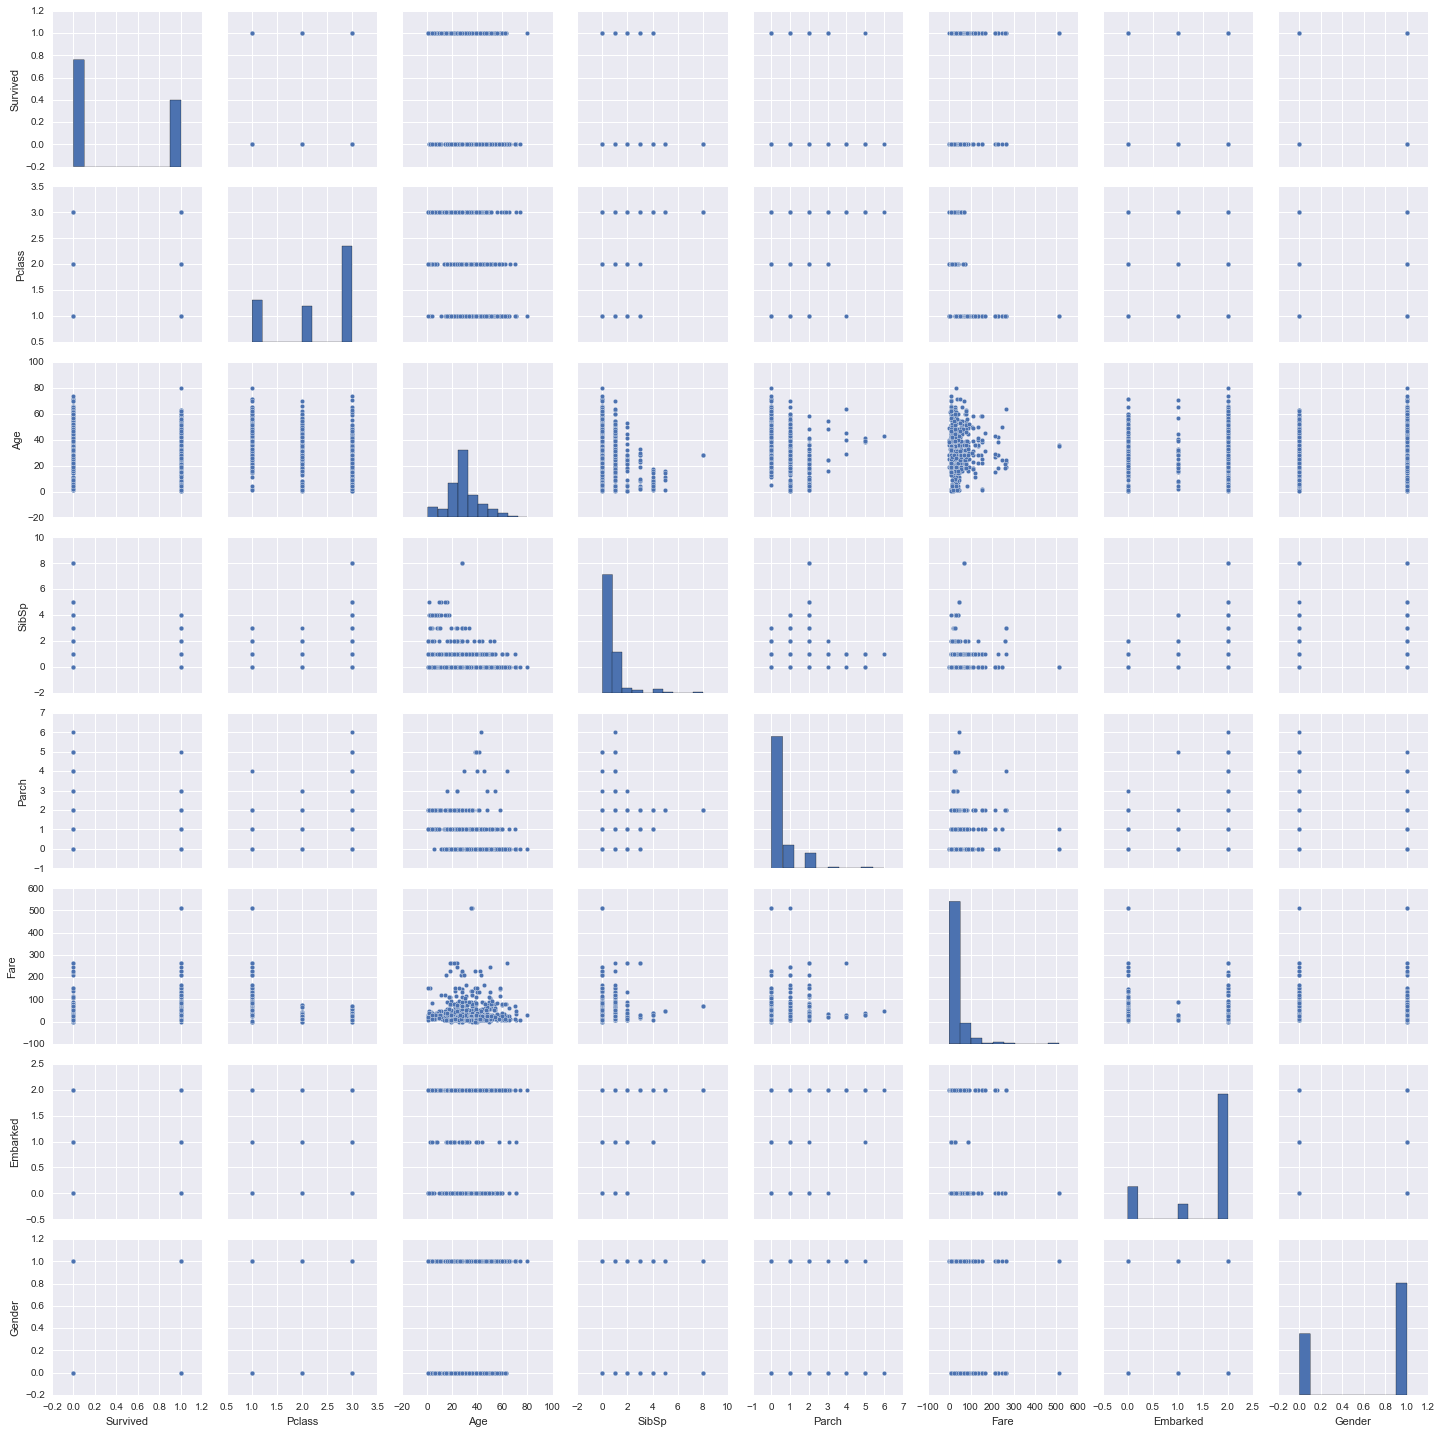

In [40]:
import seaborn as sns
%matplotlib inline
sns.pairplot(train_df_patsy)

In [37]:
train_df_patsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
Gender      891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [41]:
train_df_patsy.Pclass = train_df_patsy.Pclass.astype("category")
train_df_patsy.Embarked = train_df_patsy.Embarked.astype("category")
train_df_patsy.Gender = train_df_patsy.Gender.astype("category")


In [42]:
formula = "Survived ~ C(Pclass) + Age + SibSp + Parch + Fare + C(Embarked) + C(Gender)"
outcome, predictors = patsy.dmatrices(formula,  train_df_patsy, return_type="dataframe")


In [45]:
predictors.head()

,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Embarked)[T.1],C(Embarked)[T.2],C(Gender)[T.1],Age,SibSp,Parch,Fare
0,1.0,0.0,1.0,0.0,1.0,1.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,0.0,0.0,0.0,0.0,38.0,1.0,0.0,71.2833
2,1.0,0.0,1.0,0.0,1.0,0.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,1.0,0.0,1.0,0.0,1.0,1.0,35.0,0.0,0.0,8.0500


In [54]:
forest_patsy = RandomForestClassifier(n_estimators=100, oob_score=True)
forest_patsy.fit( predictors, outcome.Survived)

#print('Predicting...')
#output_patsy = forest.predict(test_data).astype(int)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [55]:
forest_patsy.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'random_state')

In [56]:
forest_patsy.oob_score_

0.81144781144781142